In [1]:
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt
import os
from keras.optimizers import RMSprop
import glob

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast
import cv2
from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set the image size.
img_height = 300
img_width = 300

## 1. Load a trained SSD

In [81]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = '/home/auv/Sahil/ssd_keras/fish_detection_40epochs.h5'
# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.
model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

#### or

## 2. Load trained weights


In [3]:
# 1: Build the Keras model
K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=3,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = '/home/auv/Sahil/ssd_keras/fish_detection_80x225_lr_0.0001.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
rmsprop = RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)

ssd_loss = ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=rmsprop, loss=ssd_loss.compute_loss)

## 3. Data Preparation

 Provide dataset path

In [ ]:
data_path = '/media/auv/DATA/Data/Fish_Training_Data/Test/'

In [8]:
dataset = DataGenerator()

# TODO: Set the paths to the dataset here.
pmfs_images_dir      =  os.path.join(data_path , "PMFS","images")
pmfs_annotations_dir = os.path.join(data_path , "PMFS_Annotations")
pmfs_image_set_filename      =  os.path.join(data_path ,"PMFS", 'images.txt')
pacstorm_images_dir      =  os.path.join(data_path , "Pacstorm", "images")
pacstorm_annotations_dir = os.path.join(data_path , "Pacstorm_Annotations")
pacstorm_image_set_filename      =  os.path.join(data_path , "Pacstorm",'images.txt')

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background','fish', 'starfish','sponge']

dataset.parse_xml(images_dirs=[pmfs_images_dir,pacstorm_images_dir],
                  image_set_filenames=[pmfs_image_set_filename,pacstorm_image_set_filename],
                  annotations_dirs=[pmfs_annotations_dir,pacstorm_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

Processing image set 'images.txt': 100%|██████████| 176/176 [00:00<00:00, 718.60it/s]


In [9]:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=300, width=300)

generator = dataset.generate(batch_size=464,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              resize],
                             returns={'processed_images',
                                      'filenames',
                                      'inverse_transform',
                                      'original_images',
                                      'original_labels'},
                             keep_images_without_gt=False)

here


In [10]:
# Generate a batch and make predictions.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(generator)


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

In [56]:
def visualize_prediction(original_image, pred):
    # Set the colors for the bounding boxes
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    classes = ['background','fish', 'starfish','coral', 'mud']

    plt.figure(figsize=(20,12))
    plt.imshow(original_image[0])

    current_axis = plt.gca()

    for box in pred[0]:
        # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
        xmin = box[2] * original_image[0].shape[1] / img_width
        ymin = box[3] * original_image[0].shape[0] / img_height
        xmax = box[4] * original_image[0].shape[1] / img_width
        ymax = box[5] * original_image[0].shape[0] / img_height
        
        color = colors[int(box[0])]
        label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
#########################################################################
# # # # # # # # Compare predictions with the ground-truths  # # # # # # #
#########################################################################

In [15]:
def compareVisualization(batch_original_images, y_pred_thresh_inv, index):
    # Display the image and draw the predicted boxes onto it.

    # Set the colors for the bounding boxes
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.figure(figsize=(20,12))
    plt.imshow(batch_original_images[index])

    current_axis = plt.gca()

    for box in batch_original_labels[index]:
        xmin = box[1]
        ymin = box[2]
        xmax = box[3]
        ymax = box[4]
        label = '{}'.format(classes[int(box[0])])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

    for box in y_pred_thresh_inv[index]:
        xmin = box[2]
        ymin = box[3]
        xmax = box[4]
        ymax = box[5]
        color = colors[int(box[0])]
        label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
#### Helper methods: Not required

In [12]:
# TODO: provide path dataset
files = glob.glob('/media/auv/DATA/Data/201009_PacStorm/d20100923_1/down_images/*.jpg')

In [6]:
def createImageArray(path):
    files = glob.glob(path+'/*.jpg')
    orig_images = [] # Store the images here.
    input_images = []
    for myFile in files:
        orig_images.append(imread(myFile))
        img = image.load_img(myFile, target_size=(img_height, img_width))
        img = image.img_to_array(img) 
        input_images.append(img)
    input_images = np.array(input_images)
    return orig_images, input_images

## Observations

In [ ]:
# Inferencing a single image

In [9]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = '/media/auv/DATA/Data/Fish_Training_Data/Test/Pacstorm/images/20100921.024128.06894.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

In [10]:
y_pred = model.predict(input_images)
y_pred

array([[[  2.  ,   0.64,  68.62, 236.33,  89.74, 256.95],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ]]], dtype=float32)

In [11]:
confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh)

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[array([[  2.  ,   0.64,  68.62, 236.33,  89.74, 256.95]], dtype=float32)]


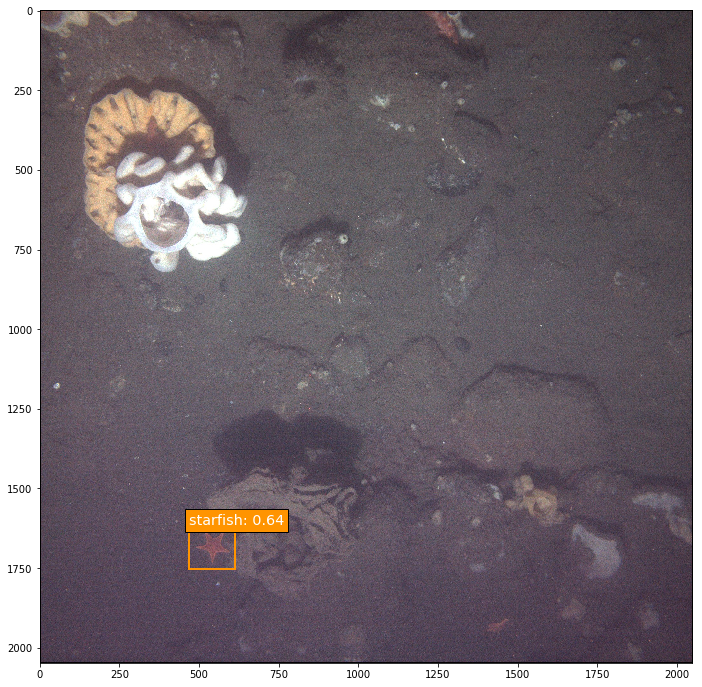

In [12]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background','fish', 'starfish','coral', 'mud']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

### Inferencing on batch images

In [11]:
# Predict.
y_pred = model.predict(batch_images)

In [12]:

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: /media/auv/DATA/Data/Fish_Training_Data/Test/PMFS/images/CCXC.20051027.03074493.0328.jpg

Ground truth boxes:

[[  2 675  23 756  98]
 [  2 181 178 279 312]
 [  3 276  30 394 122]]


In [13]:
confidence_threshold = 0.5

# Perform confidence thresholding.
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

# Convert the predictions for the original image.
y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.86   8.     1.   154.    96.  ]
 [  2.     0.52 670.    25.   761.   108.  ]]


Image: /media/auv/DATA/Data/Fish_Training_Data/Test/PMFS/images/CCXC.20051027.03074493.0328.jpg

Ground truth boxes:

[[  2 675  23 756  98]
 [  2 181 178 279 312]
 [  3 276  30 394 122]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.86   8.     1.   154.    96.  ]
 [  2.     0.52 670.    25.   761.   108.  ]]


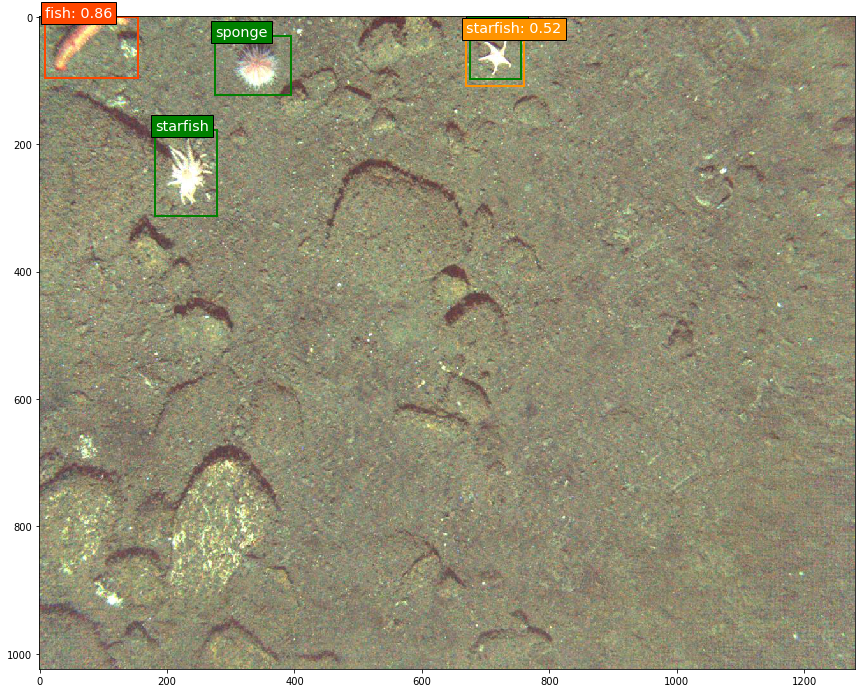

In [17]:
i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_inv[i])
compareVisualization(batch_original_images, y_pred_thresh_inv, i)

## Extra Testing

In [4]:
model.save('fish40epoch.h5')

In [13]:
orig_images = [] # Store the images here.
input_images = []
i = 1
for myFile in files:
    i += 1
    orig_images.append(imread(myFile))
    img = image.load_img(myFile, target_size=(img_height, img_width))
    img = image.img_to_array(img) 
    input_images.append(img)
input_images = np.array(input_images)

In [17]:
fish_list = []
starfish_list = []
coral_list = []


In [18]:

counter = 0
for k in range(total_predictions.shape[0]):
    for l in range(200):
        counter +=1
        #print(counter)
        if (total_predictions[k,:,0][l] == 1):
            fish_list.append(k)
        if  (total_predictions[k,:,0][l] == 2):
            starfish_list.append(k)
        if  (total_predictions[k,:,0][l] == 3):
        #    print(k)
            coral_list.append(k)
        #if(total_predictions[K,:,0][l] == 4):
        #    print(total_predictions[k,:,0][l])

In [26]:
path = '/media/auv/Untitled/200510_PMFS/Dive03_DaisyBank/images'
o,i = createImageArray(path)

In [7]:
def predictionAnalysis(total_predictions):
    fish_list = []
    starfish_list = []
    coral_list = []
    for k in range(total_predictions.shape[0]):
        for l in range(200):
            if (total_predictions[k,:,0][l] == 1):
                fish_list.append(k)
            if  (total_predictions[k,:,0][l] == 2):
                starfish_list.append(k)
            if  (total_predictions[k,:,0][l] == 3):
                coral_list.append(k)
    return fish_list, starfish_list, coral_list

In [98]:
fish_list = 0
starfish_list = 0
coral_list = 0
for l in labels:
    for i in range(len(l)):
        if (l[:][i][0]) == 1:
            fish_list += 1
        if (l[:][i][0]) == 2:
            starfish_list +=1
        if (l[:][i][0]) == 3:
            coral_list +=1
print(fish_list)
print(starfish_list)
print(coral_list)

722
212
8


In [105]:
original_fish_list = []
original_starfish_list = []
original_coral_list = []
index = 0
for l in new_list:
    index += 1
    for i in range(len(l)):
        if (l[:][i][0]) == 1:
            original_fish_list.append(index-1)
        if (l[:][i][0]) == 2:
            original_starfish_list.append(index-1)
        if (l[:][i][0]) == 3:
            original_coral_list.append(index-1)

In [91]:
pacstorm23_fish_list, pacstorm23_star_list, pacstorm23_coral_list = predictionAnalysis(total_predictions)

In [102]:
print(len(pacstorm23_fish_list))
print(len(pacstorm23_star_list))
print((pacstorm23_coral_list))

207
167
[53, 74, 117, 118, 132, 171, 172, 174, 177, 187, 188, 279, 306, 307, 313, 327, 355, 370, 378]


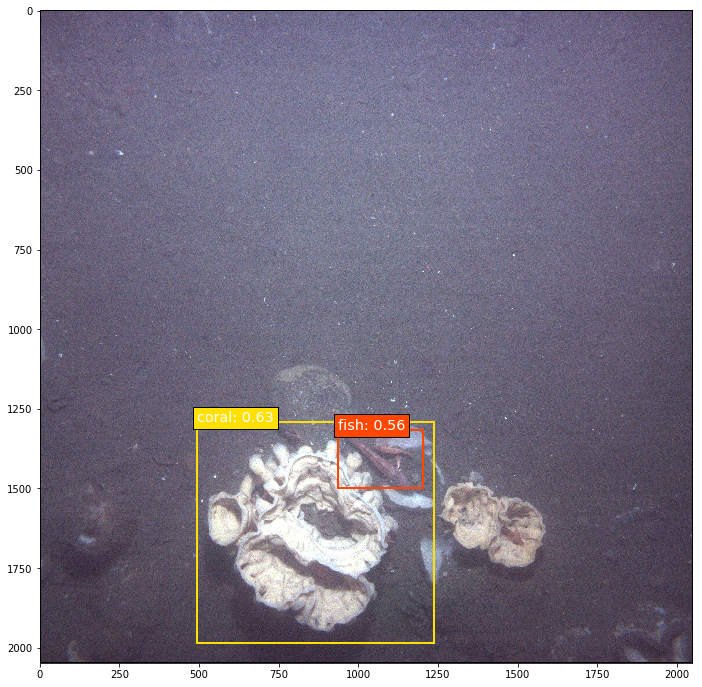

In [108]:
visualize_prediction(orig_images,total_pred_thresh,index=53)

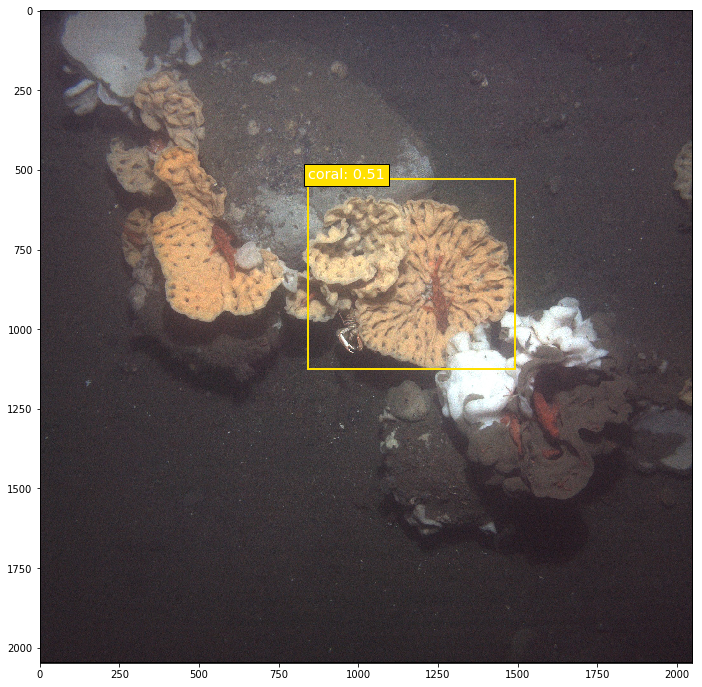

In [110]:
visualize_prediction(orig_images,total_pred_thresh,index=74)

In [4]:
labels[0]

[[1, 534, 1756, 769, 1968], [2, 178, 1715, 337, 1865]]

In [5]:
labels_format={'class_id': 0, 'xmin': 1, 'ymin': 2, 'xmax': 3, 'ymax': 4}
xmin = labels_format['xmin']
ymin = labels_format['ymin']
xmax = labels_format['xmax']
ymax = labels_format['ymax']

In [6]:
labels[:, [ymin, ymax]] = np.round(labels[:, [ymin, ymax]] * (300 / 2048), decimals=0)
labels[:, [xmin, xmax]] = np.round(labels[:, [xmin, xmax]] * (300 / 2048), decimals=0)

TypeError: list indices must be integers or slices, not tuple

In [145]:
2048/300

6

In [8]:
for l in range(len(labels)):
    if not labels[l]:
        print(l)
        

133
195
222
327
336
513
575
602
707
716


In [13]:
labels[195]

[]

In [18]:
test_fish_list, test_star_list, test_coral_list = predictionAnalysis(y_pred)

In [19]:
print('Predicted Fish List: ',len(test_fish_list))
print('Predicted StarFish List: ',len(test_star_list))
print('Predicted Coral List: ',len(test_coral_list))

Predicted Fish List:  191
Predicted StarFish List:  120
Predicted Coral List:  0


In [20]:
fish_list = 0
starfish_list = 0
coral_list = 0
for l in batch_original_labels:
    for i in range(len(l)):
        if (l[:][i][0]) == 1:
            fish_list += 1
        if (l[:][i][0]) == 2:
            starfish_list +=1
        if (l[:][i][0]) == 3:
            coral_list +=1
print('Original Fish List: ', fish_list)
print('Original Starfish List: ', starfish_list)
print('Original Coral List: ', coral_list)

Original Fish List:  274
Original Starfish List:  377
Original Coral List:  132


In [21]:
len(batch_original_labels)

464

In [22]:
batch_original_labels[0]

[[2, 675, 23, 756, 98], [2, 181, 178, 279, 312], [3, 276, 30, 394, 122]]